This is a modified notebook for the project, from the sample code downloaded originally from MedMNIST example at https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb .

In [1]:
!pip install medmnist

In [21]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import os
from pathlib import Path
import matplotlib.pyplot as plt

# Device setup
# Check for CUDA
if torch.cuda.is_available():
	device = torch.device("cuda")
	print("Using CUDA (GPU)")
	
# Check for MPS (Apple Silicon Macs)
elif torch.backends.mps.is_available():
	device = torch.device("mps")
	print("Using MPS (macOS)")
	
else:
	device = torch.device("cpu")
	print("Using CPU")

# Example usage: Move model and tensors to the selected device

import medmnist
from medmnist import INFO, Evaluator

Using MPS (macOS)


In [5]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


# We first work on a 2D dataset with size 28x28

In [32]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 30
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [90]:
# preprocessing
data_transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [92]:
import os
import torch

os.makedirs('./xai_data_28x28', exist_ok=True)

class_counts = {i: 0 for i in range(9)}  # 9 classes in PathMNIST
max_per_class = 2

for images, labels in train_loader:
    for img_tensor, label in zip(images, labels):
        label = int(label)
        if class_counts[label] >= max_per_class:
            continue

        save_path = f'./xai_data_28x28/class_{label}_{class_counts[label]}.pt'
        torch.save(img_tensor, save_path)
        class_counts[label] += 1

    if all(c >= max_per_class for c in class_counts.values()):
        break

print("Saved 2 tensor samples per class to ./xai_data_28x28/")

Saved 2 tensor samples per class to ./xai_data_28x28/


In [96]:
## Dataloader to load the saved tensor instead for explainability experiments.
## Usage: 
# from torch.utils.data import DataLoader

# xai_dataset = SavedTensorDataset('./xai_data_28x28') # or xai_data_224 for the resnet experiment
# xai_loader = DataLoader(xai_dataset, batch_size=1, shuffle=False)

# for img_tensor, label in xai_loader:
#     # Use `img_tensor` for inference, saliency, etc.
#     print(img_tensor.shape, label.item())

import os
import torch
from torch.utils.data import Dataset

class SavedTensorDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.file_list = sorted([
            f for f in os.listdir(root_dir) if f.endswith(".pt")
        ])
        self.labels = [int(f.split('_')[1]) for f in self.file_list]  # from filename

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = os.path.join(self.root_dir, self.file_list[idx])
        tensor = torch.load(file_path)
        label = self.labels[idx]
        return tensor, label

In [16]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 89996
    Root location: /Users/zhen/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-H

In [34]:
# visualization

train_dataset.montage(length=1)

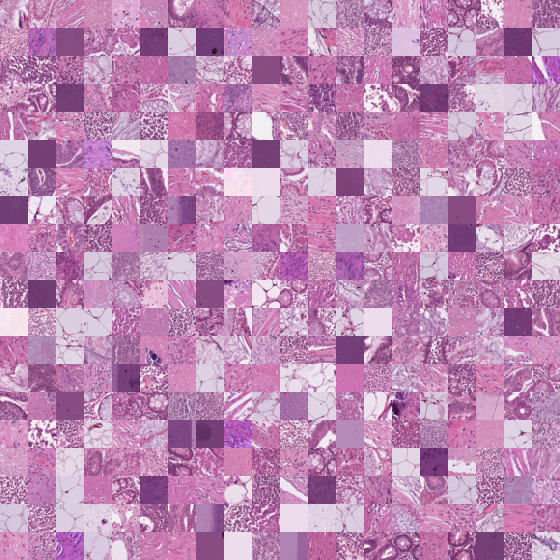

In [35]:
# montage

train_dataset.montage(length=20)

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [39]:
# define a simple CNN model

class Net(nn.Module):
	def __init__(self, in_channels, num_classes):
		super(Net, self).__init__()

		self.layer1 = nn.Sequential(
			nn.Conv2d(in_channels, 16, kernel_size=3),
			nn.BatchNorm2d(16),
			nn.ReLU())

		self.layer2 = nn.Sequential(
			nn.Conv2d(16, 16, kernel_size=3),
			nn.BatchNorm2d(16),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2, stride=2))

		self.layer3 = nn.Sequential(
			nn.Conv2d(16, 64, kernel_size=3),
			nn.BatchNorm2d(64),
			nn.ReLU())
		
		self.layer4 = nn.Sequential(
			nn.Conv2d(64, 64, kernel_size=3),
			nn.BatchNorm2d(64),
			nn.ReLU())

		self.layer5 = nn.Sequential(
			nn.Conv2d(64, 64, kernel_size=3, padding=1),
			nn.BatchNorm2d(64),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2, stride=2))

		self.fc = nn.Sequential(
			nn.Linear(64 * 4 * 4, 128),
			nn.ReLU(),
			nn.Linear(128, 128),
			nn.ReLU(),
			nn.Linear(128, num_classes))

	def forward(self, x):
		x = self.layer1(x)
		x = self.layer2(x)
		x = self.layer3(x)
		x = self.layer4(x)
		x = self.layer5(x)
		x = x.view(x.size(0), -1)
		x = self.fc(x)
		return x

model = Net(in_channels=n_channels, num_classes=n_classes).to(device)
	
# define loss function and optimizer
if task == "multi-label, binary-class":
	criterion = nn.BCEWithLogitsLoss()
else:
	criterion = nn.CrossEntropyLoss()
	
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## Next, we can start to train and evaluate!

In [40]:
# evaluation

def test(split):
	model.eval()
	y_true = torch.tensor([], device=device)
	y_score = torch.tensor([], device=device)
	
	data_loader = train_loader_at_eval if split == 'train' else test_loader

	with torch.no_grad():
		for inputs, targets in data_loader:
			inputs, targets = inputs.to(device), targets.to(device)
			outputs = model(inputs)

			if task == 'multi-label, binary-class':
				targets = targets.to(torch.float32)
				outputs = outputs.softmax(dim=-1)
			else:
				targets = targets.squeeze().long()
				outputs = outputs.softmax(dim=-1)
				targets = targets.float().resize_(len(targets), 1)

			y_true = torch.cat((y_true, targets), 0)
			y_score = torch.cat((y_score, outputs), 0)

		y_true = y_true.cpu().numpy()
		y_score = y_score.cpu().detach().numpy()
		
		evaluator = Evaluator(data_flag, split)
		metrics = evaluator.evaluate(y_score)
	
		print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

	return metrics

		
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.597  acc:0.088
test  auc: 0.602  acc:0.103


Metrics(AUC=np.float64(0.6023247569651571), ACC=0.1032033426183844)

Model saved to models/RISE_28x28_CNN_epoch_0.pt


100%|██████████| 704/704 [00:08<00:00, 80.28it/s]


test  auc: 0.973  acc:0.855
Epoch 1/30 Loss: 0.0549 Train Acc: 0.9811 Test Acc: 0.8553
Model saved to models/RISE_28x28_CNN_epoch_1.pt


100%|██████████| 704/704 [00:08<00:00, 82.58it/s]


test  auc: 0.975  acc:0.820
Epoch 2/30 Loss: 0.0461 Train Acc: 0.9845 Test Acc: 0.8202
Model saved to models/RISE_28x28_CNN_epoch_2.pt


100%|██████████| 704/704 [00:08<00:00, 81.36it/s]


test  auc: 0.976  acc:0.859
Epoch 3/30 Loss: 0.0486 Train Acc: 0.9838 Test Acc: 0.8592
Model saved to models/RISE_28x28_CNN_epoch_3.pt


100%|██████████| 704/704 [00:08<00:00, 81.28it/s]


test  auc: 0.955  acc:0.698
Epoch 4/30 Loss: 0.0463 Train Acc: 0.9842 Test Acc: 0.6983
Model saved to models/RISE_28x28_CNN_epoch_4.pt


100%|██████████| 704/704 [00:08<00:00, 81.40it/s]


test  auc: 0.951  acc:0.725
Epoch 5/30 Loss: 0.0425 Train Acc: 0.9859 Test Acc: 0.7255
Model saved to models/RISE_28x28_CNN_epoch_5.pt


100%|██████████| 704/704 [00:08<00:00, 80.77it/s]


test  auc: 0.972  acc:0.823
Epoch 6/30 Loss: 0.0527 Train Acc: 0.9830 Test Acc: 0.8234
Model saved to models/RISE_28x28_CNN_epoch_6.pt


100%|██████████| 704/704 [00:08<00:00, 82.24it/s]


test  auc: 0.972  acc:0.845
Epoch 7/30 Loss: 0.0397 Train Acc: 0.9863 Test Acc: 0.8450
Model saved to models/RISE_28x28_CNN_epoch_7.pt


100%|██████████| 704/704 [00:08<00:00, 80.39it/s]


test  auc: 0.971  acc:0.812
Epoch 8/30 Loss: 0.0338 Train Acc: 0.9886 Test Acc: 0.8123
Model saved to models/RISE_28x28_CNN_epoch_8.pt


100%|██████████| 704/704 [00:08<00:00, 81.98it/s]


test  auc: 0.967  acc:0.798
Epoch 9/30 Loss: 0.0331 Train Acc: 0.9892 Test Acc: 0.7979
Model saved to models/RISE_28x28_CNN_epoch_9.pt


100%|██████████| 704/704 [00:08<00:00, 82.31it/s]


test  auc: 0.972  acc:0.796
Epoch 10/30 Loss: 0.0445 Train Acc: 0.9855 Test Acc: 0.7964
Model saved to models/RISE_28x28_CNN_epoch_10.pt


100%|██████████| 704/704 [00:08<00:00, 80.71it/s]


test  auc: 0.972  acc:0.834
Epoch 11/30 Loss: 0.0264 Train Acc: 0.9916 Test Acc: 0.8338
Model saved to models/RISE_28x28_CNN_epoch_11.pt


100%|██████████| 704/704 [00:08<00:00, 80.05it/s]


test  auc: 0.967  acc:0.792
Epoch 12/30 Loss: 0.0259 Train Acc: 0.9919 Test Acc: 0.7922
Model saved to models/RISE_28x28_CNN_epoch_12.pt


100%|██████████| 704/704 [00:08<00:00, 80.41it/s]


test  auc: 0.973  acc:0.841
Epoch 13/30 Loss: 0.0335 Train Acc: 0.9888 Test Acc: 0.8407
Model saved to models/RISE_28x28_CNN_epoch_13.pt


100%|██████████| 704/704 [00:08<00:00, 81.15it/s]


test  auc: 0.968  acc:0.794
Epoch 14/30 Loss: 0.0268 Train Acc: 0.9916 Test Acc: 0.7944
Model saved to models/RISE_28x28_CNN_epoch_14.pt


100%|██████████| 704/704 [00:08<00:00, 81.92it/s]


test  auc: 0.970  acc:0.852
Epoch 15/30 Loss: 0.0288 Train Acc: 0.9905 Test Acc: 0.8522
Model saved to models/RISE_28x28_CNN_epoch_15.pt


100%|██████████| 704/704 [00:08<00:00, 81.80it/s]


test  auc: 0.976  acc:0.840
Epoch 16/30 Loss: 0.0204 Train Acc: 0.9938 Test Acc: 0.8404
Model saved to models/RISE_28x28_CNN_epoch_16.pt


100%|██████████| 704/704 [00:08<00:00, 81.24it/s]


test  auc: 0.970  acc:0.819
Epoch 17/30 Loss: 0.0205 Train Acc: 0.9939 Test Acc: 0.8187
Model saved to models/RISE_28x28_CNN_epoch_17.pt


100%|██████████| 704/704 [00:08<00:00, 80.97it/s]


test  auc: 0.972  acc:0.839
Epoch 18/30 Loss: 0.0309 Train Acc: 0.9903 Test Acc: 0.8393
Model saved to models/RISE_28x28_CNN_epoch_18.pt


100%|██████████| 704/704 [00:08<00:00, 81.91it/s]


test  auc: 0.977  acc:0.837
Epoch 19/30 Loss: 0.0192 Train Acc: 0.9939 Test Acc: 0.8370
Model saved to models/RISE_28x28_CNN_epoch_19.pt


100%|██████████| 704/704 [00:08<00:00, 81.31it/s]


test  auc: 0.975  acc:0.826
Epoch 20/30 Loss: 0.0199 Train Acc: 0.9935 Test Acc: 0.8265
Model saved to models/RISE_28x28_CNN_epoch_20.pt


100%|██████████| 704/704 [00:08<00:00, 81.40it/s]


test  auc: 0.971  acc:0.785
Epoch 21/30 Loss: 0.0201 Train Acc: 0.9935 Test Acc: 0.7850
Model saved to models/RISE_28x28_CNN_epoch_21.pt


100%|██████████| 704/704 [00:08<00:00, 82.28it/s]


test  auc: 0.974  acc:0.841
Epoch 22/30 Loss: 0.0205 Train Acc: 0.9932 Test Acc: 0.8405
Model saved to models/RISE_28x28_CNN_epoch_22.pt


100%|██████████| 704/704 [00:08<00:00, 81.47it/s]


test  auc: 0.966  acc:0.794
Epoch 23/30 Loss: 0.0144 Train Acc: 0.9956 Test Acc: 0.7944
Model saved to models/RISE_28x28_CNN_epoch_23.pt


100%|██████████| 704/704 [00:08<00:00, 80.63it/s]


test  auc: 0.955  acc:0.714
Epoch 24/30 Loss: 0.0156 Train Acc: 0.9952 Test Acc: 0.7143
Model saved to models/RISE_28x28_CNN_epoch_24.pt


100%|██████████| 704/704 [00:08<00:00, 80.71it/s]


test  auc: 0.976  acc:0.830
Epoch 25/30 Loss: 0.0198 Train Acc: 0.9935 Test Acc: 0.8302
Model saved to models/RISE_28x28_CNN_epoch_25.pt


100%|██████████| 704/704 [00:08<00:00, 80.81it/s]


test  auc: 0.973  acc:0.826
Epoch 26/30 Loss: 0.0132 Train Acc: 0.9964 Test Acc: 0.8260
Model saved to models/RISE_28x28_CNN_epoch_26.pt


100%|██████████| 704/704 [00:08<00:00, 80.24it/s]


test  auc: 0.973  acc:0.832
Epoch 27/30 Loss: 0.0277 Train Acc: 0.9909 Test Acc: 0.8316
Model saved to models/RISE_28x28_CNN_epoch_27.pt


100%|██████████| 704/704 [00:08<00:00, 81.51it/s]


test  auc: 0.978  acc:0.846
Epoch 28/30 Loss: 0.0137 Train Acc: 0.9956 Test Acc: 0.8461
Model saved to models/RISE_28x28_CNN_epoch_28.pt


100%|██████████| 704/704 [00:08<00:00, 81.60it/s]


test  auc: 0.964  acc:0.774
Epoch 29/30 Loss: 0.0105 Train Acc: 0.9972 Test Acc: 0.7738
Model saved to models/RISE_28x28_CNN_epoch_29.pt


100%|██████████| 704/704 [00:08<00:00, 80.78it/s]


test  auc: 0.971  acc:0.806
Epoch 30/30 Loss: 0.0116 Train Acc: 0.9966 Test Acc: 0.8064
Model saved to models/RISE_28x28_CNN_epoch_30.pt


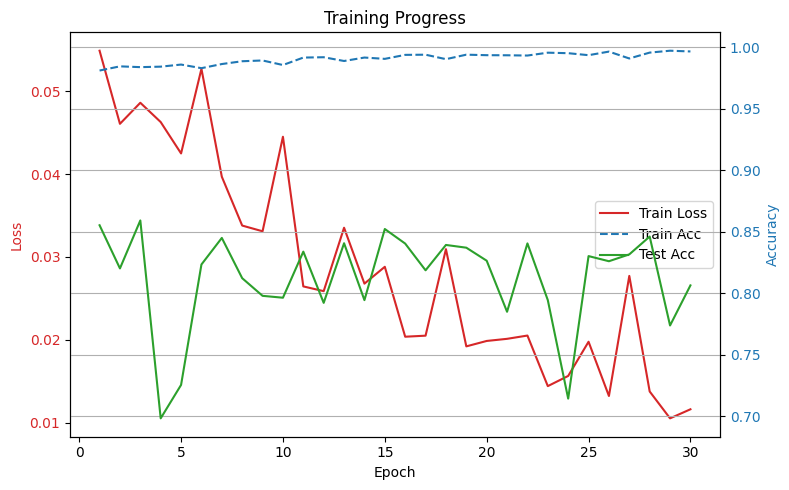

In [42]:
# Train and evaluate
EXPERIMENT_NAME = "RISE_28x28_CNN"

def save_current_model(n_epoch):
	save_path = Path(f'./models/{EXPERIMENT_NAME}_epoch_{n_epoch}.pt')
	save_path.parent.mkdir(parents=True, exist_ok=True)
	torch.save(model.state_dict(), save_path)
	print(f"Model saved to {save_path}")

save_current_model(0)

# === Tracking variables ===
train_losses = []
train_accs = []
test_accs = []

# === Training Loop ===
for epoch in range(NUM_EPOCHS):
	model.train()
	running_loss = 0.0
	correct = 0
	total = 0

	for inputs, targets in tqdm(train_loader):
		inputs, targets = inputs.to(device), targets.to(device)
		optimizer.zero_grad()
		outputs = model(inputs)

		if task == 'multi-label, binary-class':
			targets = targets.to(torch.float32)
			loss = criterion(outputs, targets)
		else:
			targets = targets.squeeze().long()
			loss = criterion(outputs, targets)
			_, predicted = outputs.max(1)
			correct += predicted.eq(targets).sum().item()
			total += targets.size(0)

		loss.backward()
		optimizer.step()
		running_loss += loss.item()

	# Store training metrics
	train_losses.append(running_loss / len(train_loader))
	if task != 'multi-label, binary-class':
		train_acc = correct / total
		train_accs.append(train_acc)
	else:
		train_metrics = test('train')  # for multi-label case, get acc from test function
		train_accs.append(train_metrics[1])  # assuming acc is at index 1

	# Evaluate on test set
	test_metrics = test('test')
	test_accs.append(test_metrics[1])  # assuming acc is at index 1

	print(f"Epoch {epoch+1}/{NUM_EPOCHS} "
		  f"Loss: {train_losses[-1]:.4f} "
		  f"Train Acc: {train_accs[-1]:.4f} "
		  f"Test Acc: {test_accs[-1]:.4f}")
	
	# === Save model ===
	save_current_model(epoch+1)

# === Plotting ===
epochs = range(1, NUM_EPOCHS + 1)

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot training loss on left y-axis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:red')
l1, = ax1.plot(epochs, train_losses, color='tab:red', label='Train Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:blue')
l2, = ax2.plot(epochs, train_accs, color='tab:blue', linestyle='--', label='Train Acc')
l3, = ax2.plot(epochs, test_accs, color='tab:green', linestyle='-', label='Test Acc')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Combine legends
lines = [l1, l2, l3]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='center right')

plt.title('Training Progress')
plt.grid(True)
plt.tight_layout()
plt.show()

# We then check a 2D dataset with size 224x224

In [93]:
data_flag = 'pathmnist'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
# train_dataset = DataClass(split='train', transform=data_transform, download=download, size=224, mmap_mode='r')
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=224, mmap_mode='r')
test_dataset = DataClass(split='test', transform=data_transform, download=download, size=224, mmap_mode='r')

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [100]:
import os
import torch

os.makedirs('./xai_data_224', exist_ok=True)

class_counts = {i: 0 for i in range(9)}  # 9 classes in PathMNIST
max_per_class = 2

for images, labels in train_loader:
    for img_tensor, label in zip(images, labels):
        label = int(label)
        if class_counts[label] >= max_per_class:
            continue

        save_path = f'./xai_data_224/class_{label}_{class_counts[label]}.pt'
        torch.save(img_tensor, save_path)
        class_counts[label] += 1

    if all(c >= max_per_class for c in class_counts.values()):
        break

print("Saved 2 tensor samples per class to ./xai_data_224/")

Saved 2 tensor samples per class to ./xai_data_224/


In [44]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST of size 224 (pathmnist_224)
    Number of datapoints: 89996
    Root location: /Users/zhen/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-

In [45]:
x, y = train_dataset[0]

print(x.shape, y.shape)

torch.Size([3, 224, 224]) (1,)


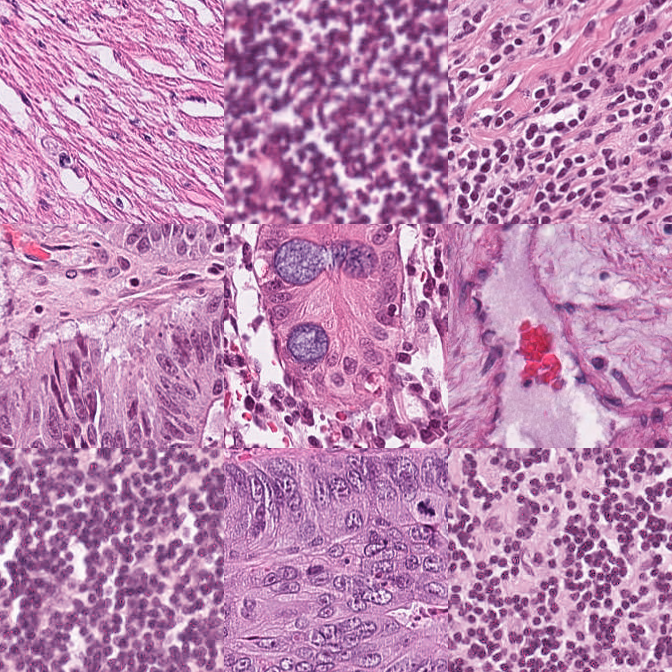

In [46]:
train_dataset.montage(length=3)

## Then we train and evaluate on this 224x224 dataset

In [47]:
from torchvision.models import resnet18

model = resnet18(num_classes=n_classes).to(device)

criterion = nn.CrossEntropyLoss()
	
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [50]:
# evaluation (on initial model)

def test(split):
	model.eval()
	y_true = torch.tensor([], device=device)
	y_score = torch.tensor([], device=device)
	
	data_loader = train_loader_at_eval if split == 'train' else test_loader

	with torch.no_grad():
		for inputs, targets in data_loader:
			inputs, targets = inputs.to(device), targets.to(device)
			outputs = model(inputs)

			if task == 'multi-label, binary-class':
				targets = targets.to(torch.float32)
				outputs = outputs.softmax(dim=-1)
			else:
				targets = targets.squeeze().long()
				outputs = outputs.softmax(dim=-1)
				targets = targets.float().resize_(len(targets), 1)

			y_true = torch.cat((y_true, targets), 0)
			y_score = torch.cat((y_score, outputs), 0)

		y_true = y_true.cpu().numpy()
		y_score = y_score.cpu().detach().numpy()
		
		evaluator = Evaluator(data_flag, split)
		metrics = evaluator.evaluate(y_score)
	
		print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))
		return metrics

		
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.992  acc:0.887
test  auc: 0.950  acc:0.722


Metrics(AUC=np.float64(0.9499000923560682), ACC=0.7224233983286908)

Model saved to models/RISE_224x224_RESTNET18_epoch_0.pt


100%|██████████| 704/704 [05:59<00:00,  1.96it/s]


test  auc: 0.965  acc:0.829
Metrics(AUC=np.float64(0.9650256873227347), ACC=0.8288300835654596)
Epoch 1/10 Loss: 0.2498 Train Acc: 0.9175 Test Acc: 0.8288
Model saved to models/RISE_224x224_RESTNET18_epoch_1.pt


100%|██████████| 704/704 [06:14<00:00,  1.88it/s]


test  auc: 0.967  acc:0.831
Metrics(AUC=np.float64(0.9672200641964412), ACC=0.8307799442896936)
Epoch 2/10 Loss: 0.1619 Train Acc: 0.9469 Test Acc: 0.8308
Model saved to models/RISE_224x224_RESTNET18_epoch_2.pt


100%|██████████| 704/704 [06:11<00:00,  1.90it/s]


test  auc: 0.956  acc:0.735
Metrics(AUC=np.float64(0.9555337776207615), ACC=0.7348189415041783)
Epoch 3/10 Loss: 0.1217 Train Acc: 0.9604 Test Acc: 0.7348
Model saved to models/RISE_224x224_RESTNET18_epoch_3.pt


100%|██████████| 704/704 [06:10<00:00,  1.90it/s]


test  auc: 0.966  acc:0.784
Metrics(AUC=np.float64(0.9663644337278878), ACC=0.7844011142061281)
Epoch 4/10 Loss: 0.1042 Train Acc: 0.9666 Test Acc: 0.7844
Model saved to models/RISE_224x224_RESTNET18_epoch_4.pt


100%|██████████| 704/704 [06:13<00:00,  1.88it/s]


test  auc: 0.974  acc:0.846
Metrics(AUC=np.float64(0.9741209657118927), ACC=0.8462395543175487)
Epoch 5/10 Loss: 0.0813 Train Acc: 0.9732 Test Acc: 0.8462
Model saved to models/RISE_224x224_RESTNET18_epoch_5.pt


100%|██████████| 704/704 [06:17<00:00,  1.86it/s]


test  auc: 0.973  acc:0.876
Metrics(AUC=np.float64(0.9734515671457152), ACC=0.8759052924791086)
Epoch 6/10 Loss: 0.0694 Train Acc: 0.9776 Test Acc: 0.8759
Model saved to models/RISE_224x224_RESTNET18_epoch_6.pt


100%|██████████| 704/704 [06:16<00:00,  1.87it/s]


test  auc: 0.977  acc:0.855
Metrics(AUC=np.float64(0.977058625490309), ACC=0.8551532033426184)
Epoch 7/10 Loss: 0.0639 Train Acc: 0.9787 Test Acc: 0.8552
Model saved to models/RISE_224x224_RESTNET18_epoch_7.pt


100%|██████████| 704/704 [06:17<00:00,  1.87it/s]


test  auc: 0.982  acc:0.869
Metrics(AUC=np.float64(0.9821678964730395), ACC=0.8688022284122563)
Epoch 8/10 Loss: 0.0527 Train Acc: 0.9826 Test Acc: 0.8688
Model saved to models/RISE_224x224_RESTNET18_epoch_8.pt


100%|██████████| 704/704 [06:18<00:00,  1.86it/s]


test  auc: 0.978  acc:0.862
Metrics(AUC=np.float64(0.9775331338079434), ACC=0.861699164345404)
Epoch 9/10 Loss: 0.0477 Train Acc: 0.9851 Test Acc: 0.8617
Model saved to models/RISE_224x224_RESTNET18_epoch_9.pt


100%|██████████| 704/704 [06:16<00:00,  1.87it/s]


test  auc: 0.974  acc:0.816
Metrics(AUC=np.float64(0.973987536788031), ACC=0.8158774373259053)
Epoch 10/10 Loss: 0.0449 Train Acc: 0.9851 Test Acc: 0.8159
Model saved to models/RISE_224x224_RESTNET18_epoch_10.pt


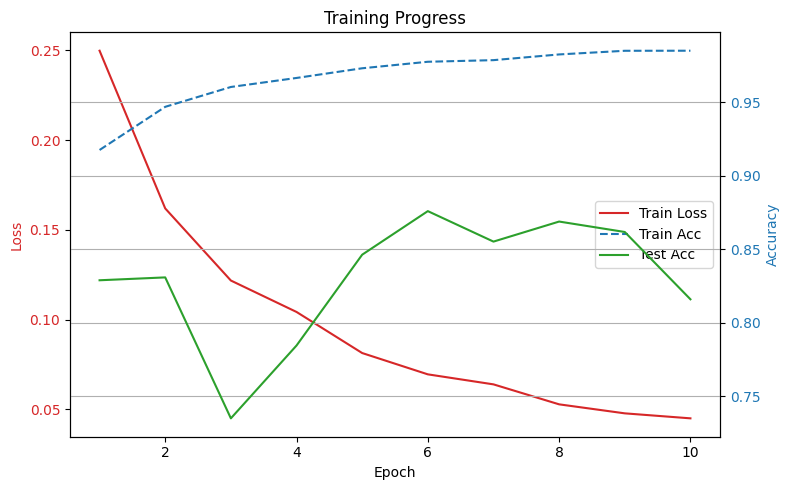

In [51]:
# Train and evaluate
EXPERIMENT_NAME = "RISE_224x224_RESTNET18"
NUM_EPOCHS = 10

def save_current_model(n_epoch):
	save_path = Path(f'./models/{EXPERIMENT_NAME}_epoch_{n_epoch}.pt')
	save_path.parent.mkdir(parents=True, exist_ok=True)
	torch.save(model.state_dict(), save_path)
	print(f"Model saved to {save_path}")

save_current_model(0)

# === Tracking variables ===
train_losses = []
train_accs = []
test_accs = []

# === Training Loop ===
for epoch in range(NUM_EPOCHS):
	model.train()
	running_loss = 0.0
	correct = 0
	total = 0

	for inputs, targets in tqdm(train_loader):
		inputs, targets = inputs.to(device), targets.to(device)
		optimizer.zero_grad()
		outputs = model(inputs)

		if task == 'multi-label, binary-class':
			targets = targets.to(torch.float32)
			loss = criterion(outputs, targets)
		else:
			targets = targets.squeeze().long()
			loss = criterion(outputs, targets)
			_, predicted = outputs.max(1)
			correct += predicted.eq(targets).sum().item()
			total += targets.size(0)

		loss.backward()
		optimizer.step()
		running_loss += loss.item()

	# Store training metrics
	train_losses.append(running_loss / len(train_loader))
	if task != 'multi-label, binary-class':
		train_acc = correct / total
		train_accs.append(train_acc)
	else:
		train_metrics = test('train')  # for multi-label case, get acc from test function
		train_accs.append(train_metrics[1])  # assuming acc is at index 1

	# Evaluate on test set
	test_metrics = test('test')
	print(test_metrics)
	test_accs.append(test_metrics[1])  # assuming acc is at index 1

	print(f"Epoch {epoch+1}/{NUM_EPOCHS} "
		  f"Loss: {train_losses[-1]:.4f} "
		  f"Train Acc: {train_accs[-1]:.4f} "
		  f"Test Acc: {test_accs[-1]:.4f}")
	
	# === Save model ===
	save_current_model(epoch+1)

# === Plotting ===
epochs = range(1, NUM_EPOCHS + 1)

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot training loss on left y-axis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:red')
l1, = ax1.plot(epochs, train_losses, color='tab:red', label='Train Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='tab:blue')
l2, = ax2.plot(epochs, train_accs, color='tab:blue', linestyle='--', label='Train Acc')
l3, = ax2.plot(epochs, test_accs, color='tab:green', linestyle='-', label='Test Acc')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Combine legends
lines = [l1, l2, l3]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='center right')

plt.title('Training Progress')
plt.grid(True)
plt.tight_layout()
plt.show()

**RISE**

In [94]:
# RISE implementation
from skimage.transform import resize
import torch.nn.functional as F

class PyTorchModelWrapper:
    def __init__(self, model, input_size, device='cpu'):
        self.model = model.to(device)
        self.device = device
        self.model.eval()
        self.input_size = input_size

    def run_on_batch(self, x):
        with torch.no_grad():
            x = torch.tensor(x.transpose(0, 3, 1, 2)).float().to(self.device)
            logits = self.model(x)
            probs = F.softmax(logits, dim=1).cpu().numpy()
        return probs
    
def generate_masks(N, s, p1):
    """
    Generate random masks for the RISE algorithm.

    Parameters:
    ----------
    N : int
        Number of masks to generate (i.e., how many masked samples will be used 
        to estimate the saliency map). A higher value leads to better estimation 
        but increases computational cost.

    s : int
        Spatial resolution of the small binary grid (s x s) before upsampling.
        Controls how coarse or fine the masks are before interpolation.
        Typical values are like 7 or 14.

    p1 : float
        Probability that each cell in the small grid is set to 1 (i.e., 
        the region is kept instead of masked). Controls the sparsity of the mask.
        Typical values not specified in the paper but is 0.5 in the RISE
        Github implementation

    Returns:
    -------
    masks : np.ndarray
        An array of shape (N, H, W, 1) containing the upsampled and randomly 
        shifted masks, where H and W match the model's input size.
    """
    cell_size = np.ceil(np.array(model.input_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *model.input_size))

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + model.input_size[0], y:y + model.input_size[1]]
    masks = masks.reshape(-1, *model.input_size, 1)
    return masks

batch_size = 100

def explain(model, inp, masks, N, p1):
    preds = []
    # Make sure multiplication is being done for correct axes
    masked = inp * masks
    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        preds.append(model.run_on_batch(masked[i:min(i+batch_size, N)]))
    preds = np.concatenate(preds)
    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *model.input_size)
    sal = sal / N / p1
    return sal

Experiment on different epochs. But didn't find much diff.

Explaining: 100%|██████████| 20/20 [00:02<00:00,  7.61it/s]
/var/folders/sx/s3ypwjlj66x3xy8r2gl04k640000gn/T/ipykernel_9821/2247437311.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_idx = int(label)


Saved: ./results/saliency_epoch_1.png
Saved: rise_epoch_1.png


Explaining: 100%|██████████| 20/20 [00:01<00:00, 10.16it/s]


Saved: ./results/saliency_epoch_2.png
Saved: rise_epoch_2.png


Explaining: 100%|██████████| 20/20 [00:01<00:00, 10.31it/s]


Saved: ./results/saliency_epoch_3.png
Saved: rise_epoch_3.png


Explaining: 100%|██████████| 20/20 [00:01<00:00, 10.21it/s]


Saved: ./results/saliency_epoch_4.png
Saved: rise_epoch_4.png


Explaining: 100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


Saved: ./results/saliency_epoch_5.png
Saved: rise_epoch_5.png


Explaining: 100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


Saved: ./results/saliency_epoch_6.png
Saved: rise_epoch_6.png


Explaining: 100%|██████████| 20/20 [00:01<00:00, 10.02it/s]


Saved: ./results/saliency_epoch_7.png
Saved: rise_epoch_7.png


Explaining: 100%|██████████| 20/20 [00:01<00:00, 10.06it/s]


Saved: ./results/saliency_epoch_8.png
Saved: rise_epoch_8.png


Explaining: 100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


Saved: ./results/saliency_epoch_9.png
Saved: rise_epoch_9.png


Explaining: 100%|██████████| 20/20 [00:01<00:00, 10.25it/s]


Saved: ./results/saliency_epoch_10.png
Saved: rise_epoch_10.png


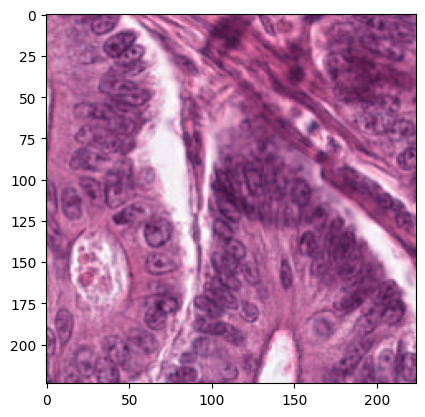

In [ ]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image

# Constants
MODEL_PATH_PATTERN = "./models/RISE_224x224_RESTNET18_epoch_{}.pt"
EPOCHS = range(1, 11)  # Adjust as needed
RESULTS_DIR = "./results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Load sample image (e.g. from PathMNIST, resized to 224x224)
transform_resize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

img_tensor, label = test_dataset[0]
img = img_tensor.numpy().transpose(1, 2, 0)
img = img * 0.5 + 0.5 
img = (img * 255).astype(np.uint8)  # Convert to uint8 [0,255]
# plt.imshow(img)
plt.imsave("./results/origin.png", img)
# RISE Parameters
N = 2000
s = 8
p1 = 0.5
input_size = (224, 224)

# Generate masks once for all runs
model = type('Temp', (), {})()  # dummy object to pass input size to mask gen
model.input_size = input_size
masks = generate_masks(N, s, p1)

# Explain with each saved model
for epoch in EPOCHS:
    model_path = MODEL_PATH_PATTERN.format(epoch)
    if not os.path.exists(model_path):
        print(f"Model not found: {model_path}")
        continue

    # Load model
    net = resnet18(num_classes=9)  # PathMNIST has 9 classes
    net.load_state_dict(torch.load(model_path, map_location='cpu'))
    net.eval()
    wrapped_model = PyTorchModelWrapper(net, input_size = (224, 224),device=device)

    # Generate saliency map
    sal = explain(wrapped_model, x, masks, N, p1)
    class_idx = int(label)

    # Plot and save
    plt.figure(figsize=(4, 4))
    plt.axis('off')
    plt.imshow(img)
    plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
    plt.title(f"Epoch {epoch} - Class {class_idx}")

    save_path = os.path.join(RESULTS_DIR, f"saliency_epoch_{epoch}.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()
    print(f"Saved: {save_path}")

    # Normalize saliency map to [0, 1]
    sal_map = sal[class_idx]
    sal_map -= sal_map.min()
    sal_map /= sal_map.max() + 1e-8

    # Convert original image and saliency to PIL
    img_pil = Image.fromarray((img * 255).astype(np.uint8))
    origin_path = os.path.join(RESULTS_DIR, "origin.png")
    if not os.path.exists(origin_path):
        img_pil.save(origin_path)
        print(f"Saved: origin.png")
    sal_color = plt.cm.jet(sal_map)[:, :, :3]  # remove alpha channel
    sal_overlay = (sal_color * 255).astype(np.uint8)
    sal_pil = Image.fromarray(sal_overlay)

    # Blend saliency with original image using 0.5 alpha
    blended = Image.blend(img_pil.convert('RGB'), sal_pil.convert('RGB'), alpha=0.3)

    # Save blended image
    blended.save(os.path.join(RESULTS_DIR, f"rise_epoch_{epoch}.png"))
    print(f"Saved: rise_epoch_{epoch}.png")




## Experiment on xai_data_224 for comparison

In [102]:
from torch.utils.data import DataLoader

xai_dataset = SavedTensorDataset('./xai_data_224') # or xai_data_224 for the resnet experiment
xai_loader = DataLoader(xai_dataset, batch_size=1, shuffle=False)

for img_tensor, label in xai_loader:
    # Use `img_tensor` for inference, saliency, etc.
    print(img_tensor.shape, label.item())


import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image

# Constants
EXPERIMENT_NAME = "RISE_ON_RESNET_XAIDATASET"
MODEL_PATH = "./models/RISE_224x224_RESTNET18_epoch_10.pt"
RESULTS_DIR = F"./results/{EXPERIMENT_NAME}"
os.makedirs(RESULTS_DIR, exist_ok=True)

# RISE Parameters
N = 2000
s = 8
p1 = 0.5
input_size = (224, 224)

# Generate masks once for all runs
model = type('Temp', (), {})()  # dummy object to pass input size to mask gen
model.input_size = input_size
masks = generate_masks(N, s, p1)

# Explain
model_path = MODEL_PATH
if not os.path.exists(model_path):
    print(f"Model not found: {model_path}")

# Load model
net = resnet18(num_classes=9)  # PathMNIST has 9 classes
net.load_state_dict(torch.load(model_path, map_location='cpu'))
net.eval()
wrapped_model = PyTorchModelWrapper(net, input_size = (224, 224),device=device)

for idx, (img_tensor, label) in enumerate(xai_loader):
    img_tensor = img_tensor.squeeze(0)  # [3, 224, 224]
    label = int(label.item())

    # Reconstruct file name using known convention
    fname = f"class_{label}_{idx % 2}"  # Assuming 2 samples per class in order

    # Unnormalize for visualization
    vis_img = img_tensor * 0.5 + 0.5
    vis_img = vis_img.mul(255).clamp(0, 255).byte().permute(1, 2, 0).numpy()
    vis_img_pil = Image.fromarray(vis_img)

    # RISE input: HWC, float32, [0,1]
    x = (vis_img / 255.0).astype(np.float32)

    # Generate saliency map
    sal = explain(wrapped_model, x, masks, N, p1)
    sal_map = sal[label]

    # Normalize saliency
    sal_map -= sal_map.min()
    sal_map /= sal_map.max() + 1e-8
    sal_color = plt.cm.jet(sal_map)[:, :, :3]
    sal_overlay = (sal_color * 255).astype(np.uint8)
    sal_pil = Image.fromarray(sal_overlay)

    # Blend with alpha
    blended = Image.blend(vis_img_pil.convert('RGB'), sal_pil.convert('RGB'), alpha=0.5)

    # Save image
    blended.save(os.path.join(RESULTS_DIR, f"rise_{fname}.png"))
    print(f"Saved: rise_{fname}.png")

torch.Size([1, 3, 224, 224]) 0
torch.Size([1, 3, 224, 224]) 0
torch.Size([1, 3, 224, 224]) 1
torch.Size([1, 3, 224, 224]) 1
torch.Size([1, 3, 224, 224]) 2
torch.Size([1, 3, 224, 224]) 2
torch.Size([1, 3, 224, 224]) 3
torch.Size([1, 3, 224, 224]) 3
torch.Size([1, 3, 224, 224]) 4
torch.Size([1, 3, 224, 224]) 4
torch.Size([1, 3, 224, 224]) 5
torch.Size([1, 3, 224, 224]) 5
torch.Size([1, 3, 224, 224]) 6
torch.Size([1, 3, 224, 224]) 6
torch.Size([1, 3, 224, 224]) 7
torch.Size([1, 3, 224, 224]) 7
torch.Size([1, 3, 224, 224]) 8
torch.Size([1, 3, 224, 224]) 8


Explaining: 100%|██████████| 20/20 [00:02<00:00,  7.55it/s]


Saved: rise_class_0_0.png


Explaining: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


Saved: rise_class_0_1.png


Explaining: 100%|██████████| 20/20 [00:02<00:00,  9.69it/s]


Saved: rise_class_1_0.png


Explaining: 100%|██████████| 20/20 [00:02<00:00,  9.71it/s]


Saved: rise_class_1_1.png


Explaining: 100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


Saved: rise_class_2_0.png


Explaining: 100%|██████████| 20/20 [00:02<00:00,  9.30it/s]


Saved: rise_class_2_1.png


Explaining: 100%|██████████| 20/20 [00:02<00:00,  9.59it/s]


Saved: rise_class_3_0.png


Explaining: 100%|██████████| 20/20 [00:02<00:00,  9.26it/s]


Saved: rise_class_3_1.png


Explaining: 100%|██████████| 20/20 [00:02<00:00,  9.60it/s]


Saved: rise_class_4_0.png


Explaining: 100%|██████████| 20/20 [00:02<00:00,  9.55it/s]


Saved: rise_class_4_1.png


Explaining: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


Saved: rise_class_5_0.png


Explaining: 100%|██████████| 20/20 [00:02<00:00,  9.65it/s]


Saved: rise_class_5_1.png


Explaining: 100%|██████████| 20/20 [00:02<00:00,  9.57it/s]


Saved: rise_class_6_0.png


Explaining: 100%|██████████| 20/20 [00:02<00:00,  9.66it/s]


Saved: rise_class_6_1.png


Explaining: 100%|██████████| 20/20 [00:02<00:00,  9.64it/s]


Saved: rise_class_7_0.png


Explaining: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


Saved: rise_class_7_1.png


Explaining: 100%|██████████| 20/20 [00:02<00:00,  9.63it/s]


Saved: rise_class_8_0.png


Explaining: 100%|██████████| 20/20 [00:02<00:00,  9.62it/s]

Saved: rise_class_8_1.png


In [ ]:
### Currently the project scope ends here. The following is from the original sample and remains unchanged.